# Fine Tuning all layers
Entrainement des modèles de l’expérience « TrainingTransferMulti.ipynb » avec tout les couches non-gelées

* Romain Capocasale
* IADeforestation
* HES-SO MASTER

# Import

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import geopandas as gpd
import pandas as pd
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tensorflow.keras.models import Model, load_model
from tensorflow.python.client import device_lib
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import LeakyReLU
from keras import backend as K 
from tensorflow.keras import metrics

from shapely import wkt

from IAdeforestation.preprocessing import *
from IAdeforestation.training import *
from IAdeforestation.spatial_cross_val import * 
from IAdeforestation.evaluation import *

/home/romain.capocasa/romain_env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
print(device_lib.list_local_devices())

K.clear_session()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12592600975854799791
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6928399072
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11771719462703000229
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
SAVED_MODELS_PATH = os.path.join('saved_models', 'all_layers_unfreeze')

In [7]:
vietnam = gpd.read_file(os.path.join("district","diaphanhuyen.shp"))

# Coffee vs other

In [9]:
train_data = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'coffee_10fold', 'train_data.csv')))
train_data['geometry'] = train_data['geometry'].apply(wkt.loads)

## Compute class weight

In [10]:
nb_0 = len(train_data[train_data['label']==0])
nb_1 = len(train_data[train_data['label']==1])
total = nb_0 + nb_1

weight_for_0 = (1 / nb_0)*(total)/2.0 
weight_for_1 = (1 / nb_1)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [11]:
nb_labels = train_data['label'].value_counts().to_dict()
prop0 = nb_labels[0]/(nb_labels[0]+nb_labels[1])
prop1 = nb_labels[1]/(nb_labels[0]+nb_labels[1])

print(prop0)
print(prop1)

0.2469879518072289
0.7530120481927711


## Train model

In [13]:
# Params
BATCH_SIZE = 64
EPOCH = 100
LEARNING_RATE = 0.0000001
DATA_AUGMENTATION_MULTIPLIATOR = 3
RUN_NAME = 'final_spacv_10FOLD_coffee_finetuning_3'

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME))
    
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      f1_score_keras
]

results = []

Epoch 1/100
63/63 [==============================] - 26s 172ms/step - loss: 0.6413 - accuracy: 0.7973 - precision: 0.9138 - recall: 0.8144 - f1_score_keras: 0.8606 - val_loss: 1.2389 - val_accuracy: 0.5664 - val_precision: 0.7266 - val_recall: 0.5503 - val_f1_score_keras: 0.6254
Epoch 2/100
63/63 [==============================] - 8s 131ms/step - loss: 0.6351 - accuracy: 0.8026 - precision: 0.9245 - recall: 0.8122 - f1_score_keras: 0.8638 - val_loss: 1.2761 - val_accuracy: 0.6172 - val_precision: 0.7429 - val_recall: 0.6265 - val_f1_score_keras: 0.6785
Epoch 3/100
63/63 [==============================] - 9s 136ms/step - loss: 0.6556 - accuracy: 0.7992 - precision: 0.9147 - recall: 0.8158 - f1_score_keras: 0.8613 - val_loss: 1.0574 - val_accuracy: 0.6719 - val_precision: 0.8000 - val_recall: 0.7006 - val_f1_score_keras: 0.7466
Epoch 4/100
63/63 [==============================] - 8s 131ms/step - loss: 0.6435 - accuracy: 0.8141 - precision: 0.9305 - recall: 0.8211 - f1_score_keras: 0.8719

63/63 [==============================] - 9s 141ms/step - loss: 0.5980 - accuracy: 0.8141 - precision: 0.9251 - recall: 0.8253 - f1_score_keras: 0.8718 - val_loss: 1.3140 - val_accuracy: 0.6953 - val_precision: 0.8205 - val_recall: 0.7191 - val_f1_score_keras: 0.7638
Epoch 60/100
63/63 [==============================] - 8s 133ms/step - loss: 0.6078 - accuracy: 0.7992 - precision: 0.9272 - recall: 0.8061 - f1_score_keras: 0.8619 - val_loss: 1.1497 - val_accuracy: 0.6992 - val_precision: 0.7945 - val_recall: 0.7117 - val_f1_score_keras: 0.7499
Epoch 61/100
63/63 [==============================] - 9s 141ms/step - loss: 0.6852 - accuracy: 0.8008 - precision: 0.9318 - recall: 0.8030 - f1_score_keras: 0.8625 - val_loss: 1.1986 - val_accuracy: 0.6953 - val_precision: 0.8163 - val_recall: 0.7018 - val_f1_score_keras: 0.7542
Epoch 62/100
63/63 [==============================] - 9s 140ms/step - loss: 0.7122 - accuracy: 0.8018 - precision: 0.9264 - recall: 0.8100 - f1_score_keras: 0.8637 - val_los

Epoch 22/100
60/60 [==============================] - 8s 142ms/step - loss: 0.9257 - accuracy: 0.8088 - precision: 0.8568 - recall: 0.8773 - f1_score_keras: 0.8661 - val_loss: 0.8057 - val_accuracy: 0.8531 - val_precision: 0.9436 - val_recall: 0.8869 - val_f1_score_keras: 0.9135
Epoch 23/100
60/60 [==============================] - 8s 136ms/step - loss: 0.9431 - accuracy: 0.8211 - precision: 0.8679 - recall: 0.8833 - f1_score_keras: 0.8743 - val_loss: 1.7614 - val_accuracy: 0.8469 - val_precision: 0.9444 - val_recall: 0.8824 - val_f1_score_keras: 0.9124
Epoch 24/100
60/60 [==============================] - 8s 141ms/step - loss: 0.9240 - accuracy: 0.8132 - precision: 0.8544 - recall: 0.8843 - f1_score_keras: 0.8683 - val_loss: 1.0655 - val_accuracy: 0.8938 - val_precision: 0.9744 - val_recall: 0.9078 - val_f1_score_keras: 0.9399
Epoch 25/100
60/60 [==============================] - 8s 140ms/step - loss: 0.9307 - accuracy: 0.8133 - precision: 0.8709 - recall: 0.8734 - f1_score_keras: 0.8

63/63 [==============================] - 9s 138ms/step - loss: 0.8221 - accuracy: 0.8285 - precision: 0.9104 - recall: 0.8699 - f1_score_keras: 0.8891 - val_loss: 2.2078 - val_accuracy: 0.7969 - val_precision: 0.8114 - val_recall: 0.8820 - val_f1_score_keras: 0.8424
Epoch 29/100
63/63 [==============================] - 9s 136ms/step - loss: 0.7947 - accuracy: 0.8300 - precision: 0.9003 - recall: 0.8825 - f1_score_keras: 0.8906 - val_loss: 0.8469 - val_accuracy: 0.7539 - val_precision: 0.7821 - val_recall: 0.8537 - val_f1_score_keras: 0.8163
Epoch 30/100
63/63 [==============================] - 8s 134ms/step - loss: 0.9679 - accuracy: 0.8226 - precision: 0.8989 - recall: 0.8729 - f1_score_keras: 0.8848 - val_loss: 0.5639 - val_accuracy: 0.8203 - val_precision: 0.8438 - val_recall: 0.8654 - val_f1_score_keras: 0.8540
Epoch 31/100
63/63 [==============================] - 9s 139ms/step - loss: 0.9351 - accuracy: 0.8270 - precision: 0.9010 - recall: 0.8774 - f1_score_keras: 0.8887 - val_los

Epoch 18/100
51/51 [==============================] - 8s 148ms/step - loss: 0.9742 - accuracy: 0.8375 - precision: 0.8746 - recall: 0.9078 - f1_score_keras: 0.8897 - val_loss: 0.5119 - val_accuracy: 0.8398 - val_precision: 0.8822 - val_recall: 0.9249 - val_f1_score_keras: 0.9023
Epoch 19/100
51/51 [==============================] - 7s 147ms/step - loss: 0.9359 - accuracy: 0.8239 - precision: 0.8760 - recall: 0.8910 - f1_score_keras: 0.8828 - val_loss: 0.5245 - val_accuracy: 0.8418 - val_precision: 0.8671 - val_recall: 0.9325 - val_f1_score_keras: 0.8985
Epoch 20/100
51/51 [==============================] - 7s 146ms/step - loss: 0.8789 - accuracy: 0.8350 - precision: 0.8815 - recall: 0.9000 - f1_score_keras: 0.8897 - val_loss: 0.4665 - val_accuracy: 0.8691 - val_precision: 0.8935 - val_recall: 0.9484 - val_f1_score_keras: 0.9193
Epoch 21/100
51/51 [==============================] - 7s 148ms/step - loss: 0.8499 - accuracy: 0.8261 - precision: 0.8817 - recall: 0.8878 - f1_score_keras: 0.8

69/69 [==============================] - 9s 130ms/step - loss: 0.8684 - accuracy: 0.8382 - precision: 0.8971 - recall: 0.8877 - f1_score_keras: 0.8918 - val_loss: 1.8391 - val_accuracy: 0.3828 - val_precision: 0.6863 - val_recall: 0.3571 - val_f1_score_keras: 0.4681
Epoch 40/100
69/69 [==============================] - 9s 127ms/step - loss: 0.8852 - accuracy: 0.8312 - precision: 0.8941 - recall: 0.8808 - f1_score_keras: 0.8862 - val_loss: 2.0791 - val_accuracy: 0.3359 - val_precision: 0.5814 - val_recall: 0.2717 - val_f1_score_keras: 0.3667
Epoch 41/100
69/69 [==============================] - 9s 130ms/step - loss: 0.9547 - accuracy: 0.8181 - precision: 0.8790 - recall: 0.8813 - f1_score_keras: 0.8797 - val_loss: 1.3625 - val_accuracy: 0.4219 - val_precision: 0.6600 - val_recall: 0.3667 - val_f1_score_keras: 0.4714
Epoch 42/100
69/69 [==============================] - 9s 133ms/step - loss: 0.8771 - accuracy: 0.8328 - precision: 0.9007 - recall: 0.8743 - f1_score_keras: 0.8866 - val_los

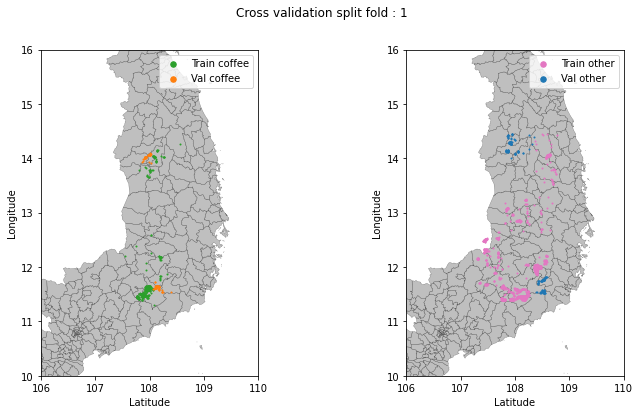

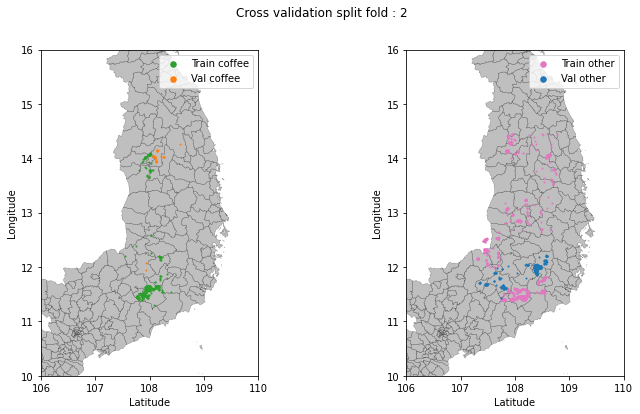

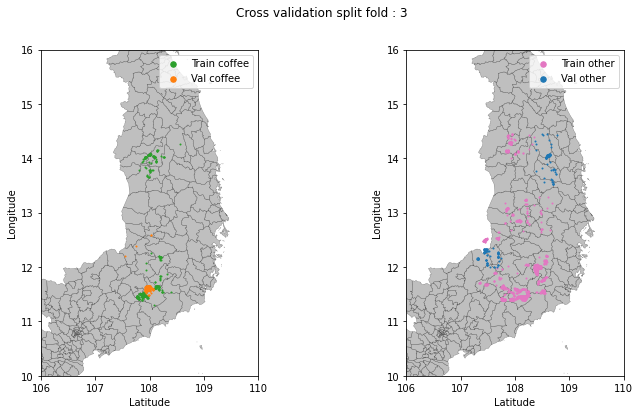

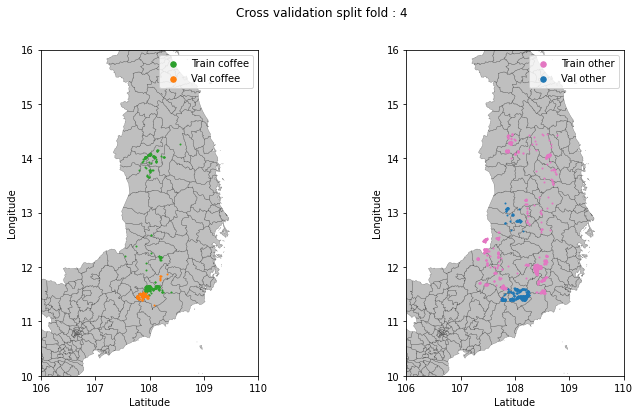

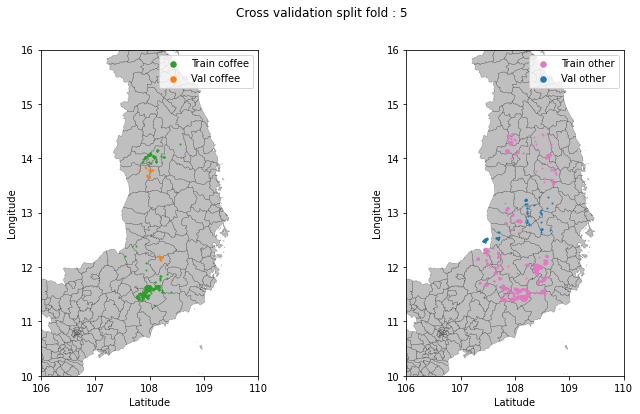

In [14]:
NB_FOLD = 5
for i_fold in range(0, NB_FOLD):
    geo_train = gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","coffee_10fold",f"train_{i_fold+1}_data.csv")))
    geo_train['geometry'] = geo_train['geometry'].apply(wkt.loads)
    
    geo_val = gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","coffee_10fold",f"val_{i_fold+1}_data.csv")))
    geo_val['geometry'] = geo_val['geometry'].apply(wkt.loads)

    display_cross_val_map_class(geo_train, geo_val, vietnam, f"Cross validation split fold : {i_fold+1}")
    
    train_generator = generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'], 
                                  eurosat_params['std'], 
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE)


    earlystopper = EarlyStopping(monitor='accuracy',patience=30,restore_best_weights=True)
      
    model = load_model(os.path.join('saved_models', 'transfer_learning', 'Coffee','final_spacv_10FOLD_coffee_1', f'final_spacv_10FOLD_coffee_1_{i_fold}' + '.h5'), compile=False, custom_objects={'LeakyReLU':LeakyReLU})
    model.trainable = True
    model.training = False
    
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

    
    history = model.fit(train_generator,
                    epochs=EPOCH,
                    steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                    validation_data=validation_generator,
                    validation_steps=len(geo_val)//BATCH_SIZE,
                    callbacks=[earlystopper],
                    class_weight=class_weight)

    
    model.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(i_fold) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(i_fold) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    results.append(result)

    print(f"Fold {i_fold+1} loss : {result[0]}")
    print(f"Fold {i_fold+1} accuracy : {result[1]}")
    print(f"Fold {i_fold+1} F1-score : {result[4]}")
    
    compute_score(geo_val, model)

    print("\n")

    K.clear_session()

In [ ]:
with open(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

In [16]:
losses, accs, precisions, recalls, f1_scores = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean F1-Score : {np.mean(f1_scores)}")
print(f"Stdev F1-Score : {np.std(f1_scores)}")

Mean accuracy : 0.71640625
Stdev accuracy : 0.20247190680900648


Mean loss : 1.2398543238639832
Stdev loss : 0.6127322493020467


Mean precision : 0.8260431408882141
Stdev precision : 0.09028249568660528


Mean recall : 0.7595576822757721
Stdev recall : 0.24706326094661488


Mean F1-Score : 0.7726247012615204
Stdev F1-Score : 0.19428372451131237


## Loss and accs plots

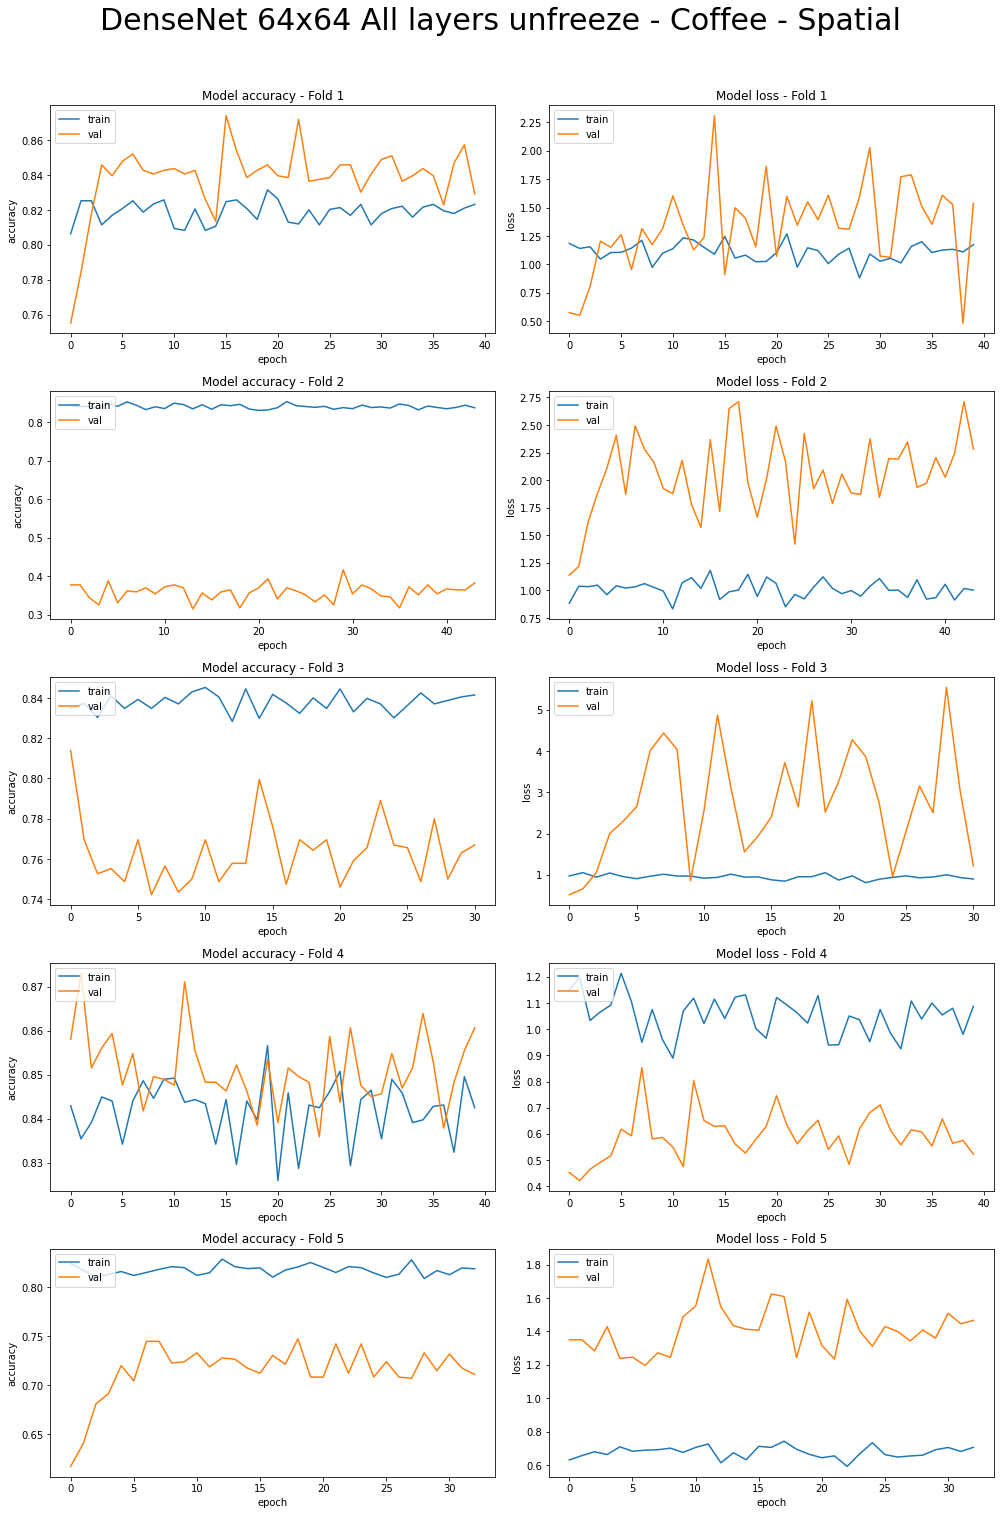

In [4]:
path = os.path.join(SAVED_MODELS_PATH, 'Coffee', 'final_spacv_10FOLD_coffee_finetuning_1')
plot_acc_loss(path, "DenseNet 64x64 All layers unfreeze - Coffee - Spatial")

# Culture vs no-culture

In [9]:
# Params
BATCH_SIZE = 64
EPOCH = 100
LEARNING_RATE = 0.0000001
DATA_AUGMENTATION_MULTIPLIATOR = 2
RUN_NAME = 'final_spacv_10FOLD_culture_finetuning_2'

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME))
    
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      f1_score_keras
]

results = []

Epoch 1/100
40/40 [==============================] - 23s 204ms/step - loss: 0.6355 - accuracy: 0.8543 - precision: 0.8159 - recall: 0.8361 - f1_score_keras: 0.8230 - val_loss: 0.3570 - val_accuracy: 0.8750 - val_precision: 0.8551 - val_recall: 0.9077 - val_f1_score_keras: 0.8783
Epoch 2/100
40/40 [==============================] - 5s 134ms/step - loss: 0.6690 - accuracy: 0.8565 - precision: 0.8379 - recall: 0.8250 - f1_score_keras: 0.8306 - val_loss: 0.3399 - val_accuracy: 0.8750 - val_precision: 0.8438 - val_recall: 0.9000 - val_f1_score_keras: 0.8714
Epoch 3/100
40/40 [==============================] - 5s 136ms/step - loss: 0.5190 - accuracy: 0.8699 - precision: 0.8335 - recall: 0.8658 - f1_score_keras: 0.8480 - val_loss: 0.2672 - val_accuracy: 0.9297 - val_precision: 0.8971 - val_recall: 0.9683 - val_f1_score_keras: 0.9289
Epoch 4/100
40/40 [==============================] - 5s 135ms/step - loss: 0.7621 - accuracy: 0.8407 - precision: 0.8474 - recall: 0.7800 - f1_score_keras: 0.8125

Epoch 16/100
38/38 [==============================] - 5s 139ms/step - loss: 0.6641 - accuracy: 0.8611 - precision: 0.8809 - recall: 0.7617 - f1_score_keras: 0.8181 - val_loss: 0.7774 - val_accuracy: 0.7604 - val_precision: 0.8421 - val_recall: 0.7207 - val_f1_score_keras: 0.7764
Epoch 17/100
38/38 [==============================] - 5s 136ms/step - loss: 0.6427 - accuracy: 0.8679 - precision: 0.8965 - recall: 0.7710 - f1_score_keras: 0.8310 - val_loss: 1.2735 - val_accuracy: 0.7344 - val_precision: 0.8286 - val_recall: 0.7250 - val_f1_score_keras: 0.7701
Epoch 18/100
38/38 [==============================] - 5s 138ms/step - loss: 0.6261 - accuracy: 0.8715 - precision: 0.8928 - recall: 0.7722 - f1_score_keras: 0.8255 - val_loss: 1.1312 - val_accuracy: 0.7396 - val_precision: 0.8667 - val_recall: 0.6724 - val_f1_score_keras: 0.7550
Epoch 19/100
38/38 [==============================] - 5s 140ms/step - loss: 0.6293 - accuracy: 0.8830 - precision: 0.8917 - recall: 0.7871 - f1_score_keras: 0.8

Epoch 23/100
36/36 [==============================] - 5s 142ms/step - loss: 0.5666 - accuracy: 0.8530 - precision: 0.8573 - recall: 0.8384 - f1_score_keras: 0.8454 - val_loss: 5.1731 - val_accuracy: 0.8242 - val_precision: 0.6129 - val_recall: 0.6441 - val_f1_score_keras: 0.6097
Epoch 24/100
36/36 [==============================] - 5s 142ms/step - loss: 0.5285 - accuracy: 0.8508 - precision: 0.8595 - recall: 0.8224 - f1_score_keras: 0.8396 - val_loss: 1.4149 - val_accuracy: 0.8750 - val_precision: 0.7083 - val_recall: 0.6538 - val_f1_score_keras: 0.6783
Epoch 25/100
36/36 [==============================] - 5s 143ms/step - loss: 0.5590 - accuracy: 0.8508 - precision: 0.8444 - recall: 0.8427 - f1_score_keras: 0.8405 - val_loss: 0.9183 - val_accuracy: 0.8281 - val_precision: 0.6034 - val_recall: 0.6250 - val_f1_score_keras: 0.5983
Epoch 26/100
36/36 [==============================] - 5s 144ms/step - loss: 0.5481 - accuracy: 0.8538 - precision: 0.8375 - recall: 0.8567 - f1_score_keras: 0.8

32/32 [==============================] - 5s 151ms/step - loss: 0.6508 - accuracy: 0.8541 - precision: 0.9434 - recall: 0.7649 - f1_score_keras: 0.8454 - val_loss: 1.0248 - val_accuracy: 0.7812 - val_precision: 0.5455 - val_recall: 0.4000 - val_f1_score_keras: 0.4488
Epoch 29/100
32/32 [==============================] - 5s 154ms/step - loss: 0.6048 - accuracy: 0.8620 - precision: 0.9459 - recall: 0.7732 - f1_score_keras: 0.8510 - val_loss: 1.8071 - val_accuracy: 0.7005 - val_precision: 0.5286 - val_recall: 0.3109 - val_f1_score_keras: 0.3916
Epoch 30/100
32/32 [==============================] - 5s 152ms/step - loss: 0.6300 - accuracy: 0.8646 - precision: 0.9480 - recall: 0.7810 - f1_score_keras: 0.8558 - val_loss: 1.5491 - val_accuracy: 0.7604 - val_precision: 0.5192 - val_recall: 0.2872 - val_f1_score_keras: 0.3706
Epoch 31/100
32/32 [==============================] - 5s 152ms/step - loss: 0.6507 - accuracy: 0.8535 - precision: 0.9379 - recall: 0.7591 - f1_score_keras: 0.8386 - val_los

Epoch 21/100
32/32 [==============================] - 5s 152ms/step - loss: 0.6378 - accuracy: 0.8490 - precision: 0.8050 - recall: 0.7935 - f1_score_keras: 0.7988 - val_loss: 1.0041 - val_accuracy: 0.7161 - val_precision: 0.7613 - val_recall: 0.7839 - val_f1_score_keras: 0.7724
Epoch 22/100
32/32 [==============================] - 5s 152ms/step - loss: 0.5817 - accuracy: 0.8559 - precision: 0.7949 - recall: 0.8209 - f1_score_keras: 0.8057 - val_loss: 0.8027 - val_accuracy: 0.7656 - val_precision: 0.8039 - val_recall: 0.8367 - val_f1_score_keras: 0.8198
Epoch 23/100
32/32 [==============================] - 5s 152ms/step - loss: 0.5780 - accuracy: 0.8560 - precision: 0.7935 - recall: 0.8102 - f1_score_keras: 0.8013 - val_loss: 0.9571 - val_accuracy: 0.7344 - val_precision: 0.7711 - val_recall: 0.8101 - val_f1_score_keras: 0.7897
Epoch 24/100
32/32 [==============================] - 5s 154ms/step - loss: 0.6290 - accuracy: 0.8486 - precision: 0.7919 - recall: 0.8179 - f1_score_keras: 0.8

32/32 [==============================] - 5s 151ms/step - loss: 0.4359 - accuracy: 0.8902 - precision: 0.8392 - recall: 0.8466 - f1_score_keras: 0.8428 - val_loss: 0.9794 - val_accuracy: 0.7448 - val_precision: 0.8201 - val_recall: 0.7809 - val_f1_score_keras: 0.7998
Epoch 80/100
32/32 [==============================] - 5s 151ms/step - loss: 0.6254 - accuracy: 0.8649 - precision: 0.8045 - recall: 0.8159 - f1_score_keras: 0.8095 - val_loss: 0.9738 - val_accuracy: 0.7500 - val_precision: 0.7879 - val_recall: 0.7948 - val_f1_score_keras: 0.7892
Epoch 81/100
32/32 [==============================] - 5s 153ms/step - loss: 0.5602 - accuracy: 0.8628 - precision: 0.8299 - recall: 0.8083 - f1_score_keras: 0.8164 - val_loss: 1.0125 - val_accuracy: 0.7422 - val_precision: 0.7835 - val_recall: 0.7870 - val_f1_score_keras: 0.7847
Epoch 82/100
32/32 [==============================] - 5s 152ms/step - loss: 0.5042 - accuracy: 0.8631 - precision: 0.8082 - recall: 0.8174 - f1_score_keras: 0.8113 - val_los

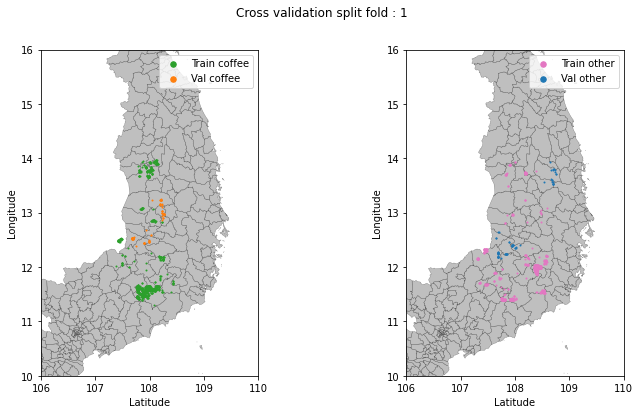

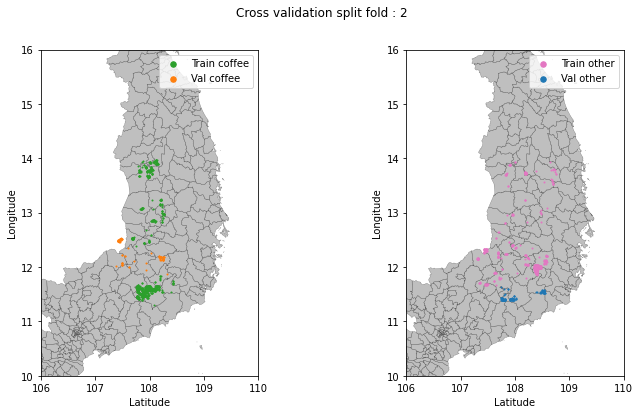

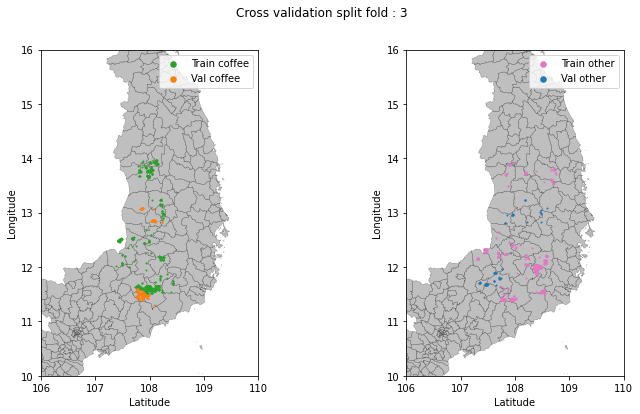

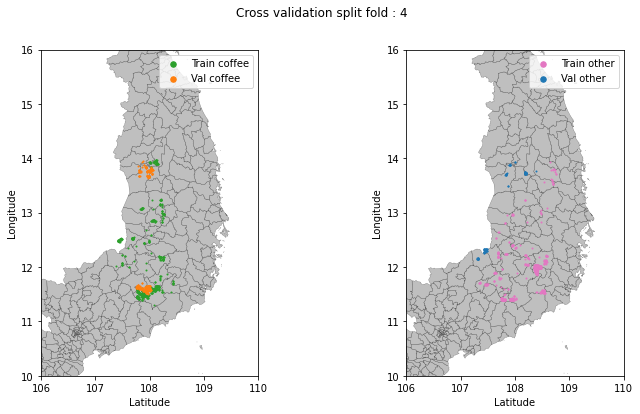

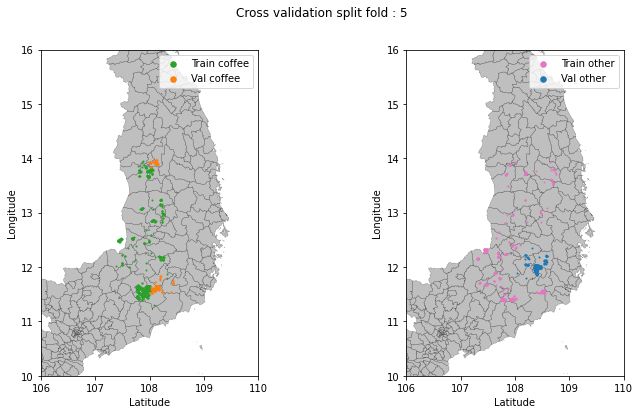

In [10]:
NB_FOLD = 5
for i_fold in range(0, NB_FOLD):
    geo_train = gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","culture_10fold",f"train_{i_fold+1}_data.csv")))
    geo_train['geometry'] = geo_train['geometry'].apply(wkt.loads)
    
    geo_val = gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","culture_10fold",f"val_{i_fold+1}_data.csv")))
    geo_val['geometry'] = geo_val['geometry'].apply(wkt.loads)

    display_cross_val_map_class(geo_train, geo_val, vietnam, f"Cross validation split fold : {i_fold+1}")
    
    train_generator = generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'], 
                                  eurosat_params['std'], 
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE)


    earlystopper = EarlyStopping(monitor='accuracy',patience=30,restore_best_weights=True)
      
    model = load_model(os.path.join('saved_models', 'transfer_learning', 'Culture','final_spacv_10FOLD_culture_ds2', f'final_spacv_10FOLD_culture_ds2_{i_fold}' + '.h5'), compile=False, custom_objects={'LeakyReLU':LeakyReLU})
    model.trainable = True
    model.training = False
    
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

    
    history = model.fit(train_generator,
                    epochs=EPOCH,
                    steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                    validation_data=validation_generator,
                    validation_steps=len(geo_val)//BATCH_SIZE,
                    callbacks=[earlystopper])

    
    model.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '_'+ str(i_fold) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '_'+ str(i_fold) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    results.append(result)

    print(f"Fold {i_fold+1} loss : {result[0]}")
    print(f"Fold {i_fold+1} accuracy : {result[1]}")
    print(f"Fold {i_fold+1} F1-score : {result[4]}")
    
    compute_score(geo_val, model)

    print("\n")

    K.clear_session()

In [11]:
with open(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

In [12]:
losses, accs, precisions, recalls, f1_scores = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean F1-Score : {np.mean(f1_scores)}")
print(f"Stdev F1-Score : {np.std(f1_scores)}")

Mean accuracy : 0.8046875
Stdev accuracy : 0.09742159307296817


Mean loss : 1.7719234585762025
Stdev loss : 1.620585398525984


Mean precision : 0.7558430910110474
Stdev precision : 0.14558283954510476


Mean recall : 0.6996039569377899
Stdev recall : 0.17272165669327616


Mean F1-Score : 0.713822853565216
Stdev F1-Score : 0.16669907551660393


## Loss and accs plots

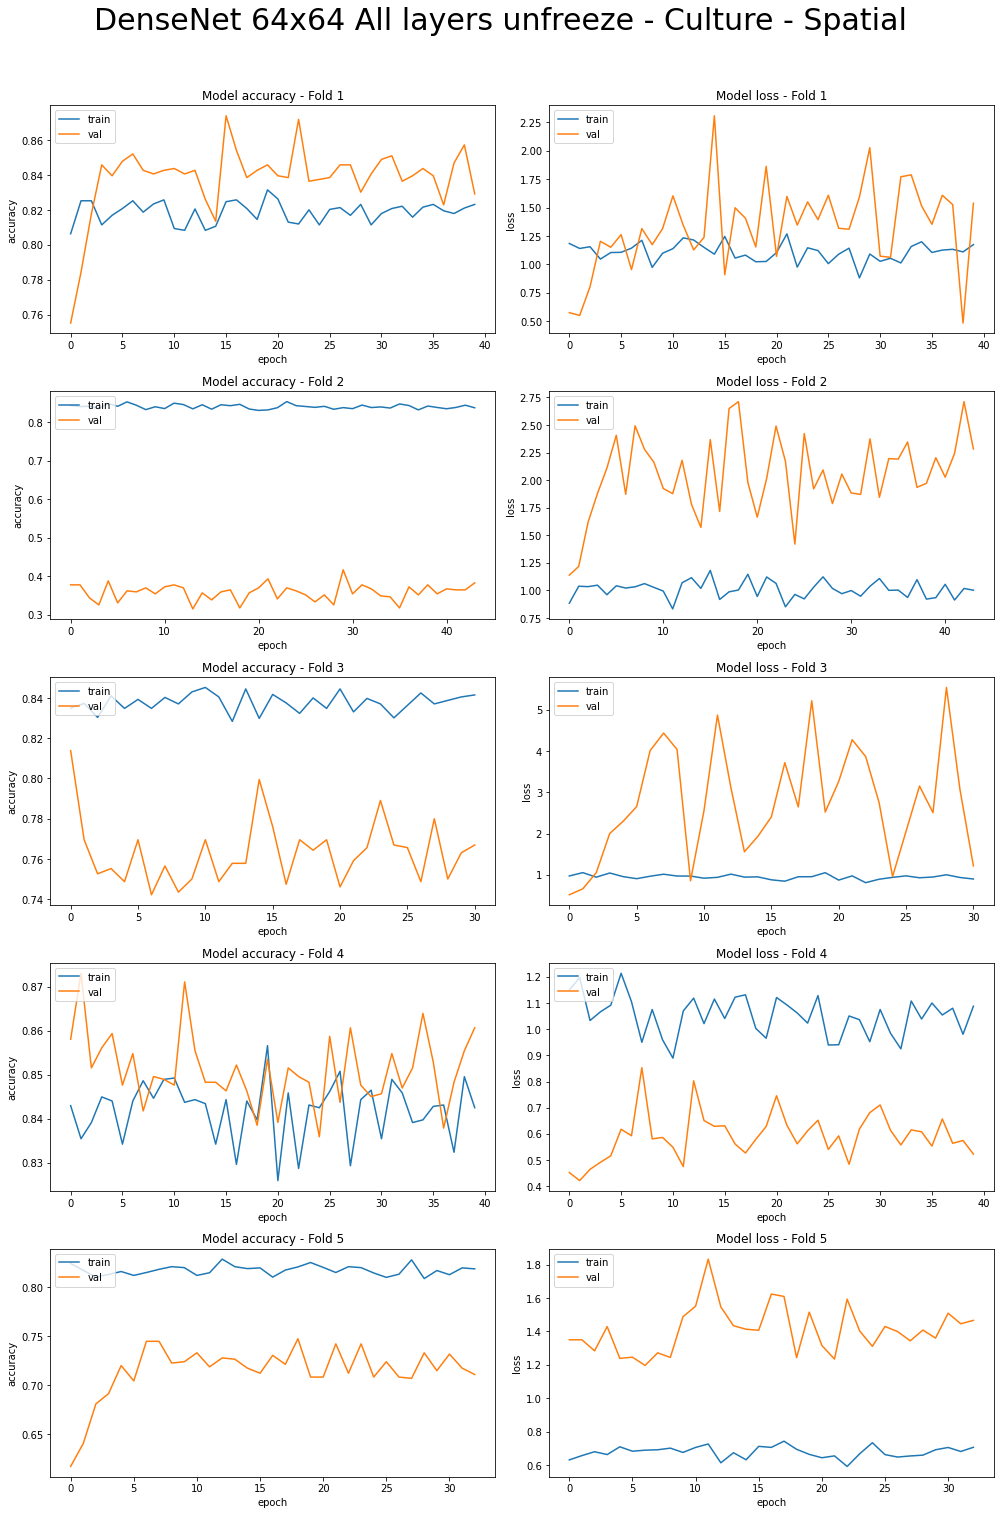

In [5]:
path = os.path.join(SAVED_MODELS_PATH, 'Coffee', 'final_spacv_10FOLD_coffee_finetuning_1')
plot_acc_loss(path, "DenseNet 64x64 All layers unfreeze - Culture - Spatial")